# Исследование успешности игр

В нашем распоряжении датасет по продаже компютерных игр в интернет-магазине «Стримчик». Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков»

## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
plt.style.use('dark_background')

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


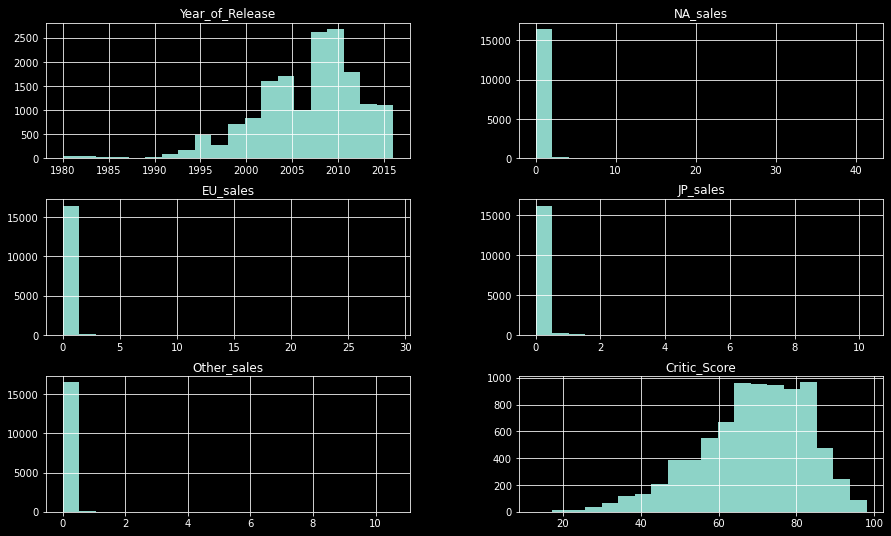

In [6]:
df.hist(bins=20, figsize=(15, 9));

In [7]:
df.duplicated().sum()

0

## Предобработка данных

### Приведем название столбцов к нижнему регистру

In [8]:
df.columns = df.columns.str.lower()

### Преобразуем данные в нужные типы

В столбце "year_of_release" уберем дробную часть преобразуем в тип данных int, а также столбец "user_score" преобразуем в тип данных float для возможности дальнейшей обработки данных.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Для изменения типа данных в этих столбцах нам необходимо удалить или преобразовать некоторые данные. 

### Обработка пропусков

In [10]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

В столбце "year_of_release" пропущено 269 значений, часть значений можно было бы восстановить, опираясь на название игры, но есть примеры, когда год в названии игры не совпадаем с годом релиза. Поэтому, чтобы не ошибиться и еще больше не искозить результаты анализа, лучше от таких данных просто избавиться. Удалим строки не содержащие год и преобразуем данные столбца в тип int.

In [11]:
df = df.loc[~df['year_of_release'].isna()]
df['year_of_release'] = df['year_of_release'].astype(int)

Пропущенные значения в столбцах "name" и "genre" можно также убрать, их всего две строки и вляение на результат будут оказывать минимальное, а данные будут выглядеть чище.

In [12]:
df = df.loc[~df['name'].isna()]

В столбце "user_score" присутствует оценка tbd, которая означает, что оценка "To Be Determined", то есть "Будет определено". Для анализа и определения мер центральной тенденции необходимо данные в этом столбце заменить на числовой тип, в данном случае float. Заменим tbd на NaN, имеющий тип float.

In [13]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('NaN')

Преобразуем тип данных в столбце 'user_score' в float

In [14]:
df['user_score'] = df['user_score'].astype(float)

Основные причины присутствия пропусков связаны с человеческим фактором, в столбцах "name", "year_of_release", "genre" ошибка занесения в базу данных, в столбцах "critic_score", "user_score" отсутствие желания или возможности со стороны критиков и пользователей вытсавить оценку, а в столбце "rating" причины две: 1. компания Entertainment Software Rating Board (ESRB) была основана только в 1994 года и игры, вышедшие до этого года логично могут не иметь рейтинг, а 2. отсутствие желания у производителя игр получать соответсвующий рейтинг, т.к. компания возможно не государственная и получения ретинга не регулируется законодательством.

In [15]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

DataFrame стал намного чище и с ним уже можно работать.

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.


In [16]:
df['general_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [17]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,general_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Т.к. ESRB это рейтинг игр в США и Канаде, для игр без рейтинга поставим заглушку tbd.

In [18]:
df['rating'].fillna('tbd')

0          E
1        tbd
2          E
3          E
4        tbd
        ... 
16710    tbd
16711    tbd
16712    tbd
16713    tbd
16714    tbd
Name: rating, Length: 16444, dtype: object

## Исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы.

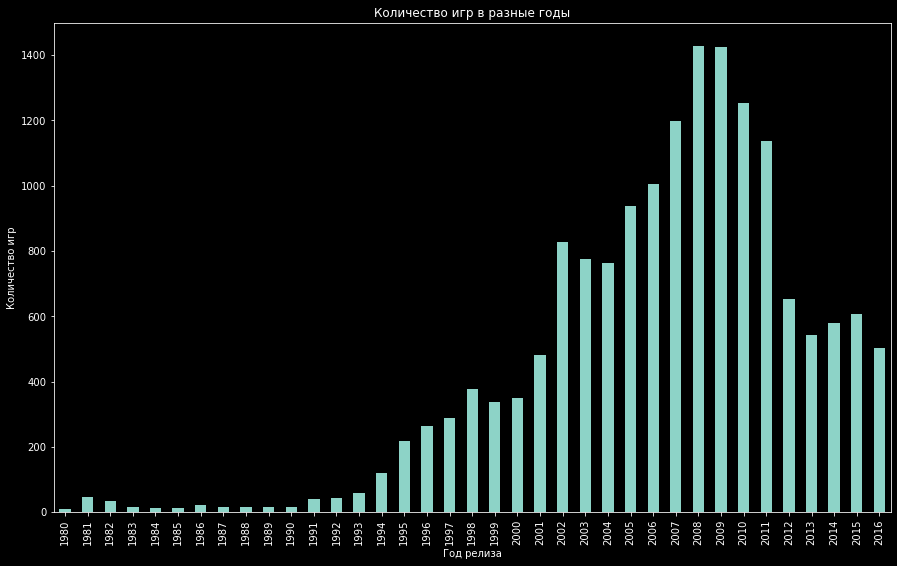

In [19]:
df.groupby('year_of_release')['name'].count().plot(kind='bar',figsize=(15,9))

plt.xlabel('Год релиза')
plt.ylabel('Количество игр')
plt.title("Количество игр в разные годы");

Из гистограммы видно, что до середины 90-х годов развитие игр шло низкими темпами и количество выпускаемых игр в год сильно ниже, чем в последуюшие годы. Пик популярности был в 2008-2009 годы, затем в 2012 году продажи сократились более, чем в два раза. Построим boxplot для точного определения выбросов

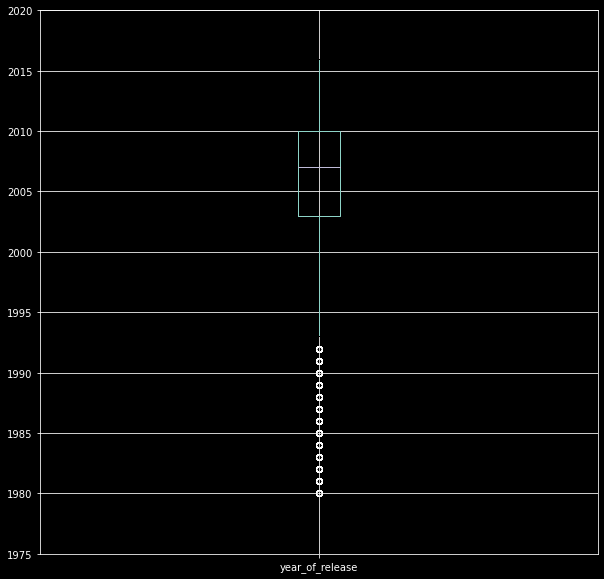

In [20]:
df.boxplot(column='year_of_release', figsize=(10,10), grid=True)
plt.ylim(1975, 2020)
plt.xlim(0, 2);

Из графика видно, что данные до 1993 года являются выбросами данной выборки и могут искозить результаты анализа и прогноз на 2017 год.

In [21]:
df = df[df['year_of_release'] > 1992]

### Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам.

In [22]:
biggest_platform = df.groupby('platform')['general_sales'].sum().sort_values(ascending=False).head(15).index

In [23]:
df[df['platform'].isin(list(biggest_platform))]\
    .pivot_table(index='year_of_release', columns='platform', values='general_sales', aggfunc='sum')

platform,3DS,DS,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,Wii,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,
1994,NaN,NaN,NaN,NaN,NaN,12.87,6.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,NaN,NaN,4.22,35.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,34.10,10.58,94.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,39.50,11.27,136.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,NaN,49.24,3.26,169.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,NaN,57.87,4.74,144.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,NaN,NaN,0.07,NaN,33.97,4.66,96.37,39.17,NaN,NaN,NaN,NaN,NaN,0.99,NaN
2001,NaN,NaN,61.53,26.34,3.25,5.47,35.59,166.43,NaN,NaN,NaN,NaN,NaN,22.26,NaN
2002,NaN,NaN,74.16,51.81,0.08,8.57,6.67,205.38,NaN,NaN,NaN,NaN,NaN,48.01,NaN


In [24]:
biggest_platform_per_year = df[df['platform'].isin(list(biggest_platform))]\
    .pivot_table(index='year_of_release', columns='platform', values='general_sales', aggfunc='sum')

Для лучшей наглядности построим heatmap.

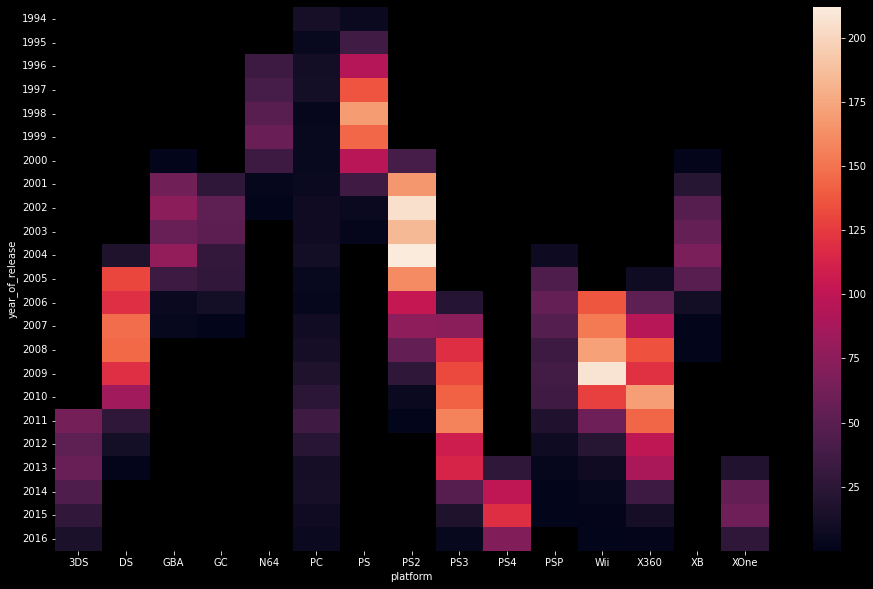

In [25]:
plt.figure(figsize = (16,10))
sns.heatmap(biggest_platform_per_year);

In [26]:
df[df['platform'].isin(list(biggest_platform))].groupby(['platform'])['year_of_release'].nunique()\
    .sort_values(ascending=False)

platform
PC      23
PS2     12
PSP     12
X360    12
PS3     11
Wii     11
DS      10
PS      10
XB       9
GBA      8
GC       7
N64      7
3DS      6
PS4      4
XOne     4
Name: year_of_release, dtype: int64

Из анализа видно, что платформы "живут" от 6 до 12 лет, если не считать PC, которая мне кажется будет жить вечно, но пик продаж в основном приходится на следующие 5 лет после первого года существования, далее постепенное снижение до полного прекращения. До 2000 года новые платформы появлялись редко, но с началом нулевых началось активное развитие и с 2004 по 2006 год новые платформы появлялись каждый год, далее наступил спад и с 2011 года появилось всего три новые платформы. 

### Определим актуальность данных, а также растующие и падающие платформы.

Из предыдущего анализа видно, что в 2012 году продажи упали в два раза, далее спад сильно снизился и если грубо выразится, то ситуация с продажами стабилизировалась. Поэтому актуальный период для дальнейшего анализа и построения прогноза на 2017 год последние 5 лет с 2012 года по 2016 год.

In [27]:
df = df[df['year_of_release'] > 2011]

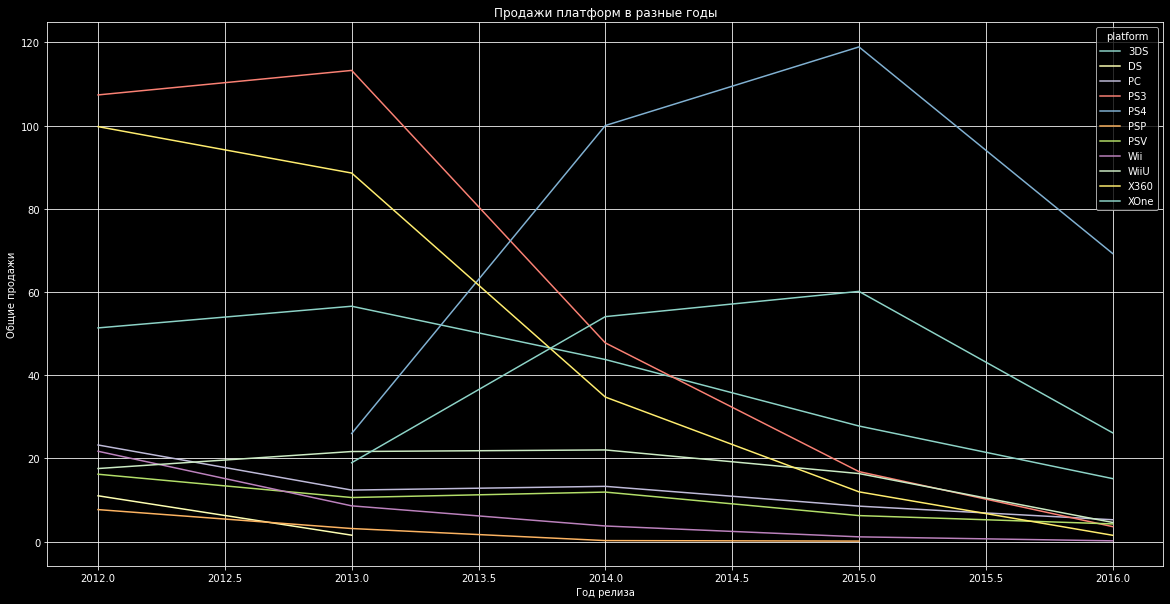

In [28]:
df.pivot_table(index='year_of_release', columns='platform', values='general_sales', aggfunc='sum')\
    .plot(figsize=(20,10), grid=True)

plt.xlabel('Год релиза')
plt.ylabel('Общие продажи')
plt.title("Продажи платформ в разные годы");

У всех плантформ наблюдается снижение продаж, но т.к. сейчас декабрь 2016, велика вероятность, что данные дополнятся и кривая немного выравнится. Настоящий момент потенциально прибыльная платформой остается PS4 и XOne, у остальных наблюдается давольно сильное снижение продаж относительно лидеров.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

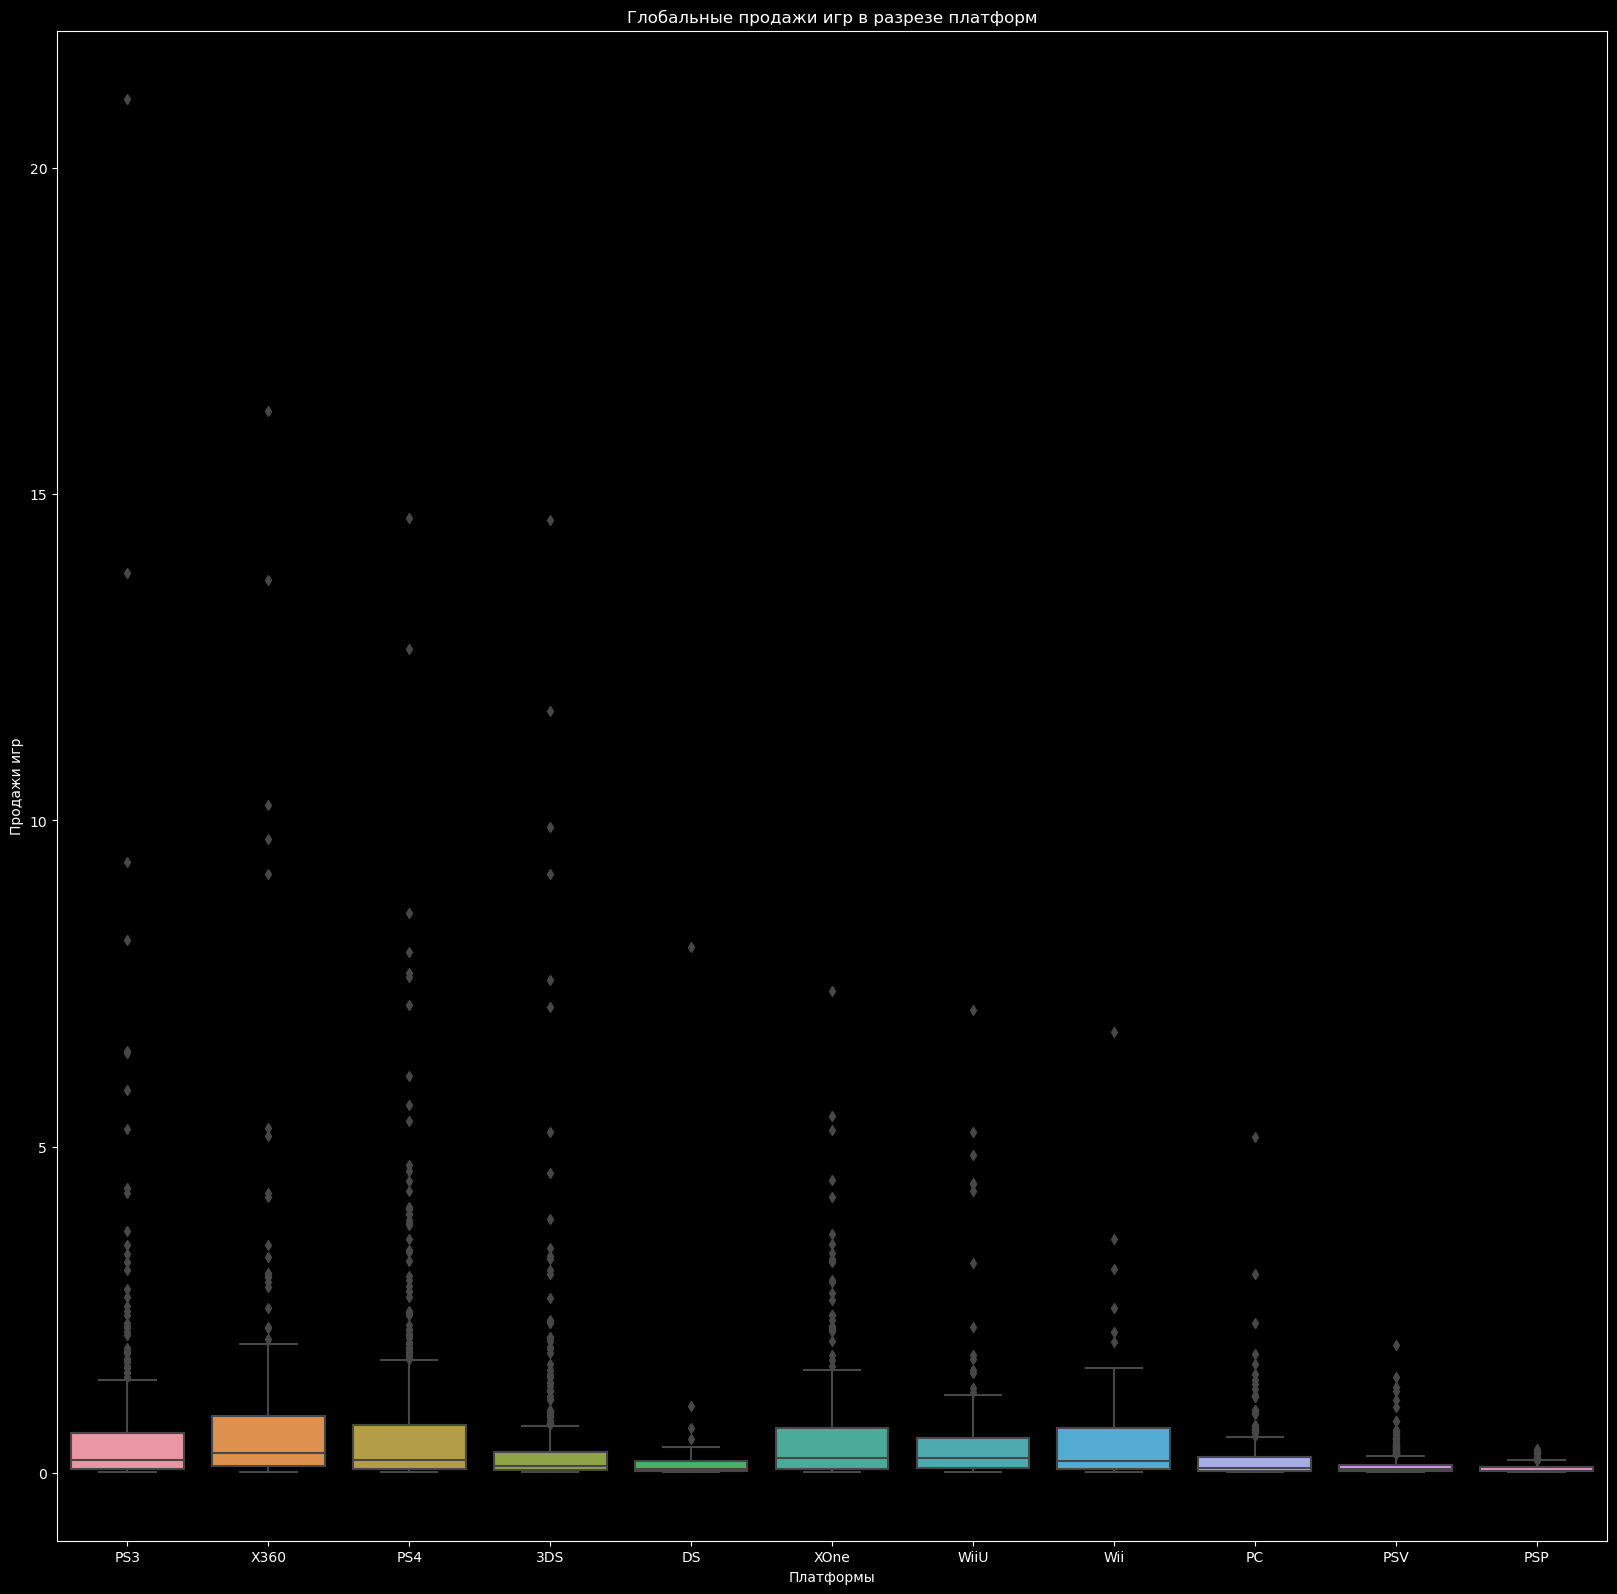

In [29]:
fig, ax = plt.subplots(figsize=(20,20), dpi=100)

sns.boxplot(data=df, x='platform', y='general_sales', ax=ax)

plt.xlabel('Платформы')
plt.ylabel('Продажи игр')
plt.title("Глобальные продажи игр в разрезе платформ");

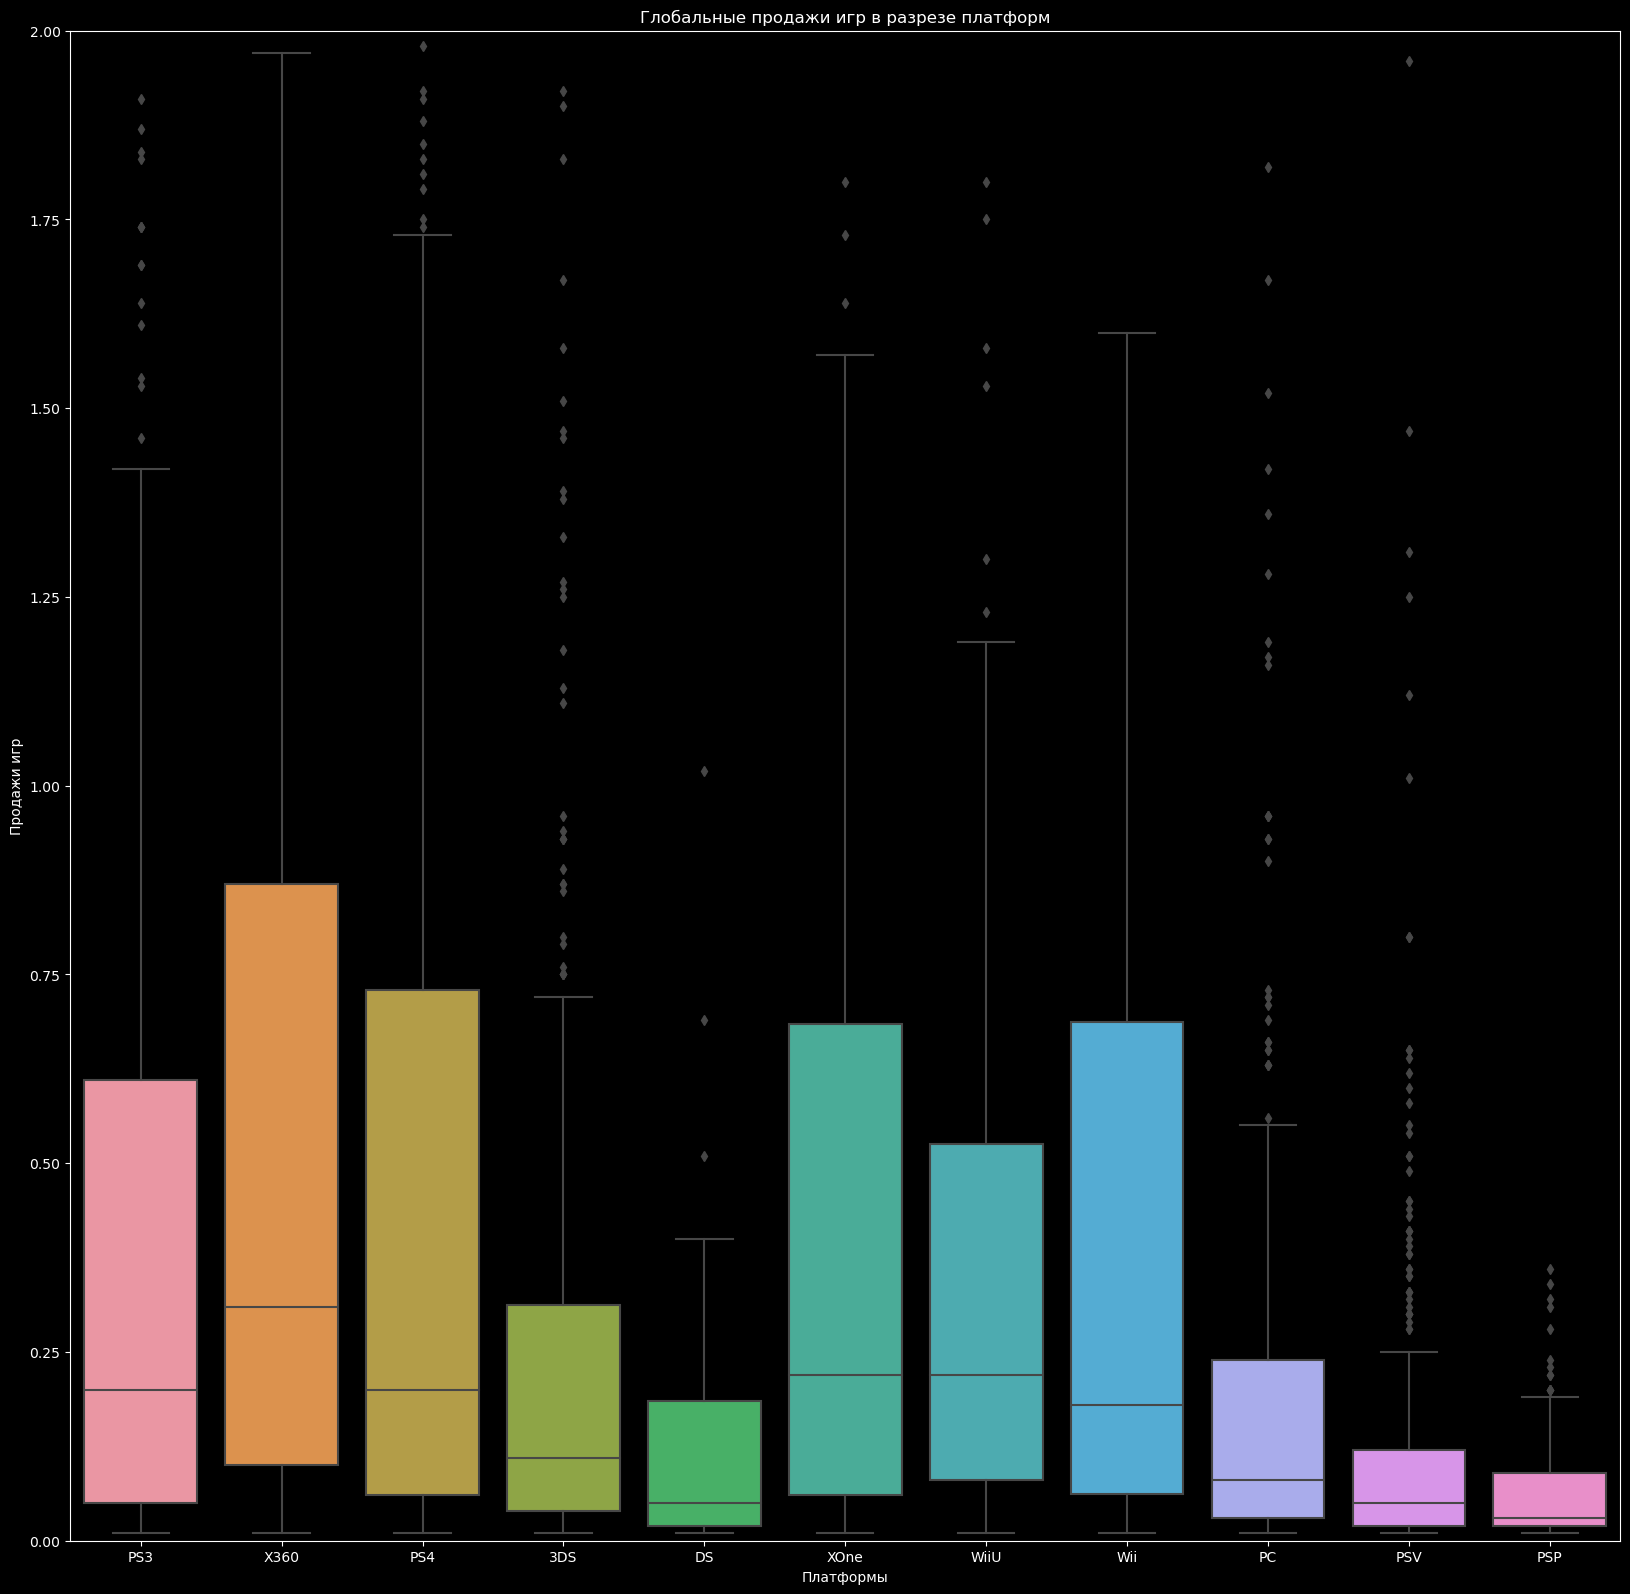

In [30]:
fig, ax = plt.subplots(figsize=(20,20), dpi=100)

sns.boxplot(data=df, x='platform', y='general_sales', ax=ax)
plt.ylim(0, 2)

plt.xlabel('Платформы')
plt.ylabel('Продажи игр')
plt.title("Глобальные продажи игр в разрезе платформ");

Из графиков boxplot видно, что ТОПовые продажи были у многих платформ при этом самые высокие медианные значения у платформ X360, что говорит о большей популярности данной платформы среди конкурентов.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

In [31]:
df = df[df['year_of_release'] > 2011]

In [32]:
def corr_and_plot(name_platform):
    df1 = df.loc[df['platform'] == name_platform, ['name','critic_score', 'user_score', 'general_sales']]

    fig, axis = plt.subplots(2,2, figsize=(18,10))

    sns.heatmap(df1.corr(), annot=True, ax=axis[0,0])
    sns.scatterplot(data=df1, x="general_sales", y="critic_score", ax=axis[0,1], hue="general_sales", size="general_sales")
    sns.scatterplot(data=df1, x="general_sales", y="user_score", ax=axis[1,0], hue="general_sales", size="general_sales")
    sns.scatterplot(data=df1, x="critic_score", y="user_score", ax=axis[1,1], hue="critic_score", size="critic_score");

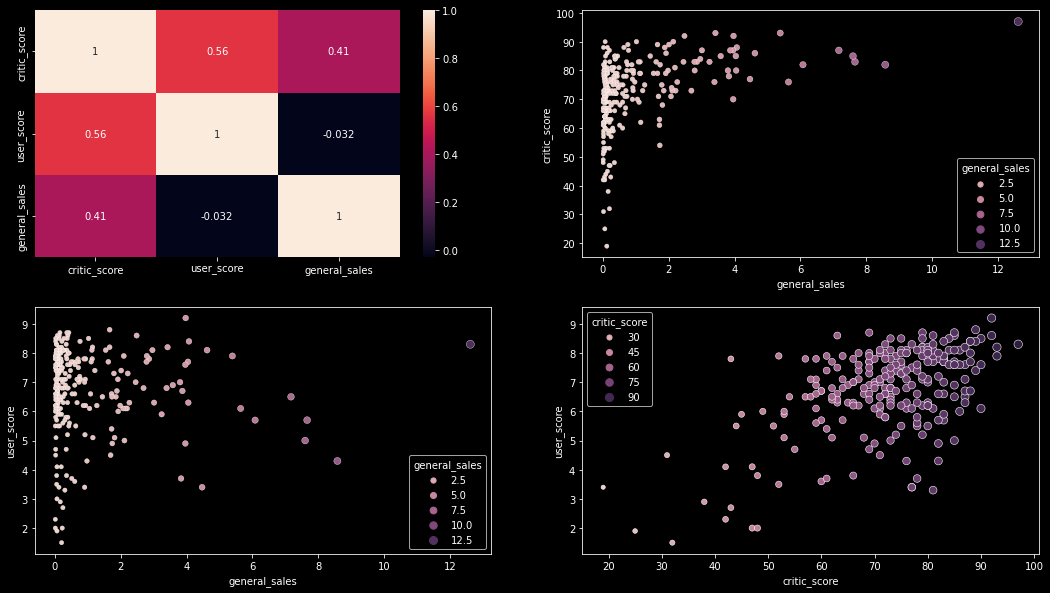

In [33]:
corr_and_plot('PS4')

У платформы "PS4" продажи с отзывами пользователей коррелируются слабо отрицательно, сильнее корреляция с оценками критиков, но больше всего оценки пользователей и критиков коррелируются между собой.

### Соотнесите выводы с продажами игр на других платформах.

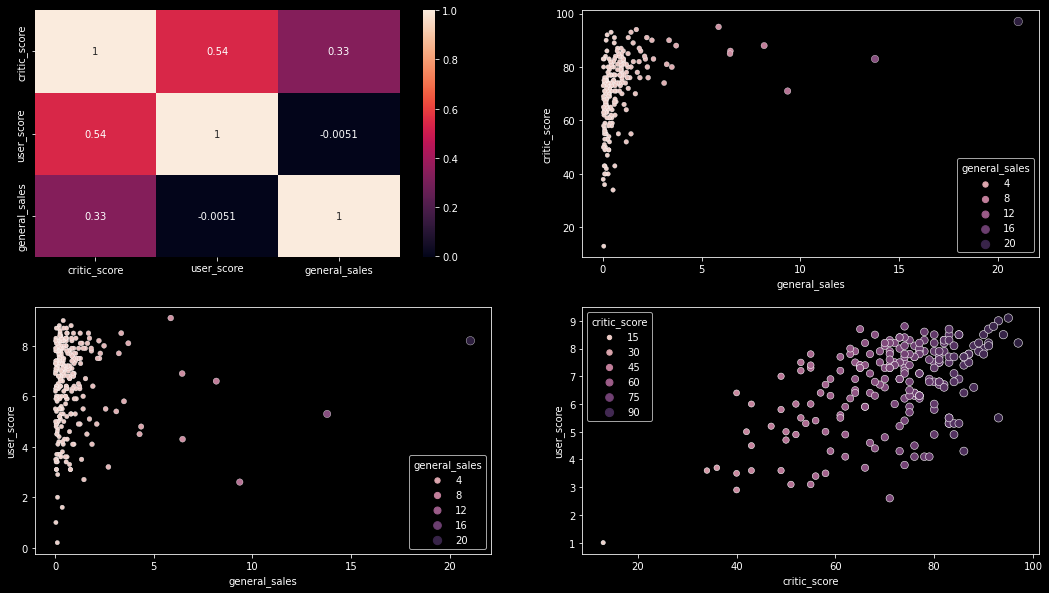

In [34]:
corr_and_plot('PS3')

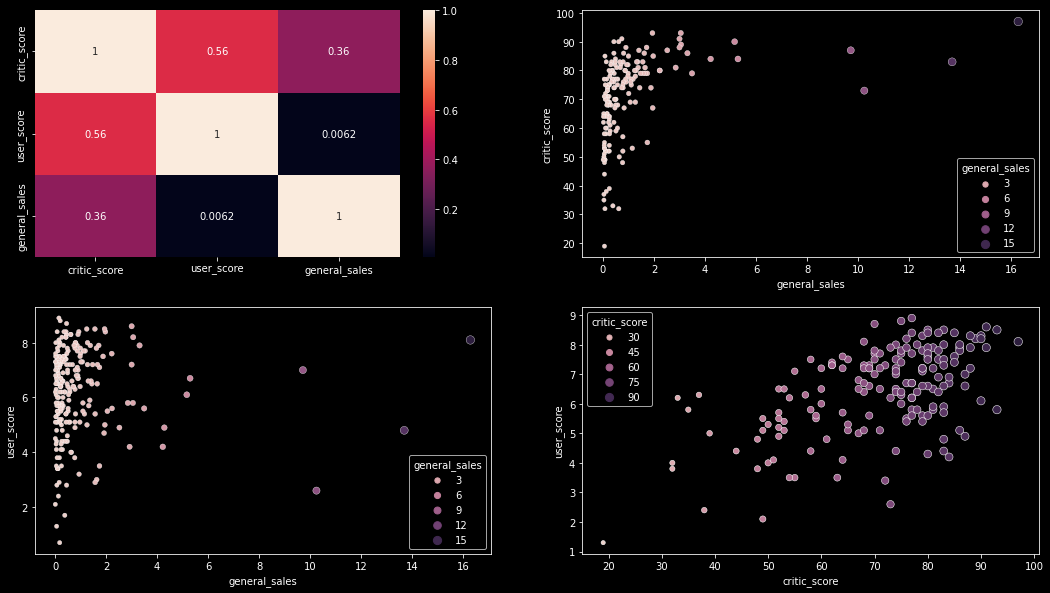

In [35]:
corr_and_plot('X360')

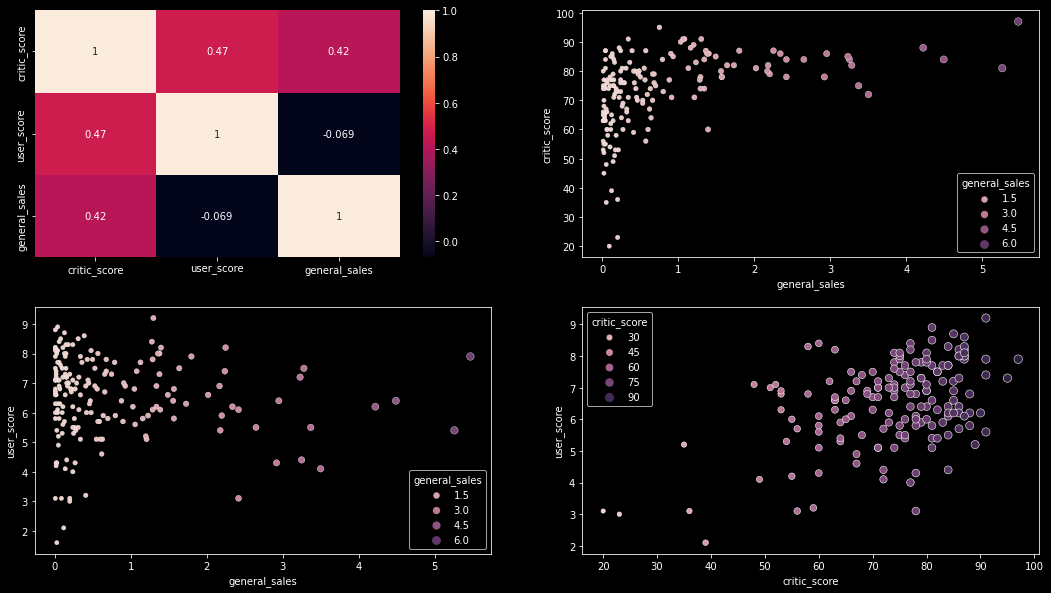

In [36]:
corr_and_plot('XOne')

По другим платформам ситуация аналогичная. Могу предположить, что на продажи влияли не только оценки критиков и пользователей, но и другие факторы, например маркетинговое сопровождение каждого релиза новой игры, поэтому корреляция не выглядит такой явной, а в некоторых случая ее почти нет.

### Посмотрим на общее распределение игр по жанрам. 

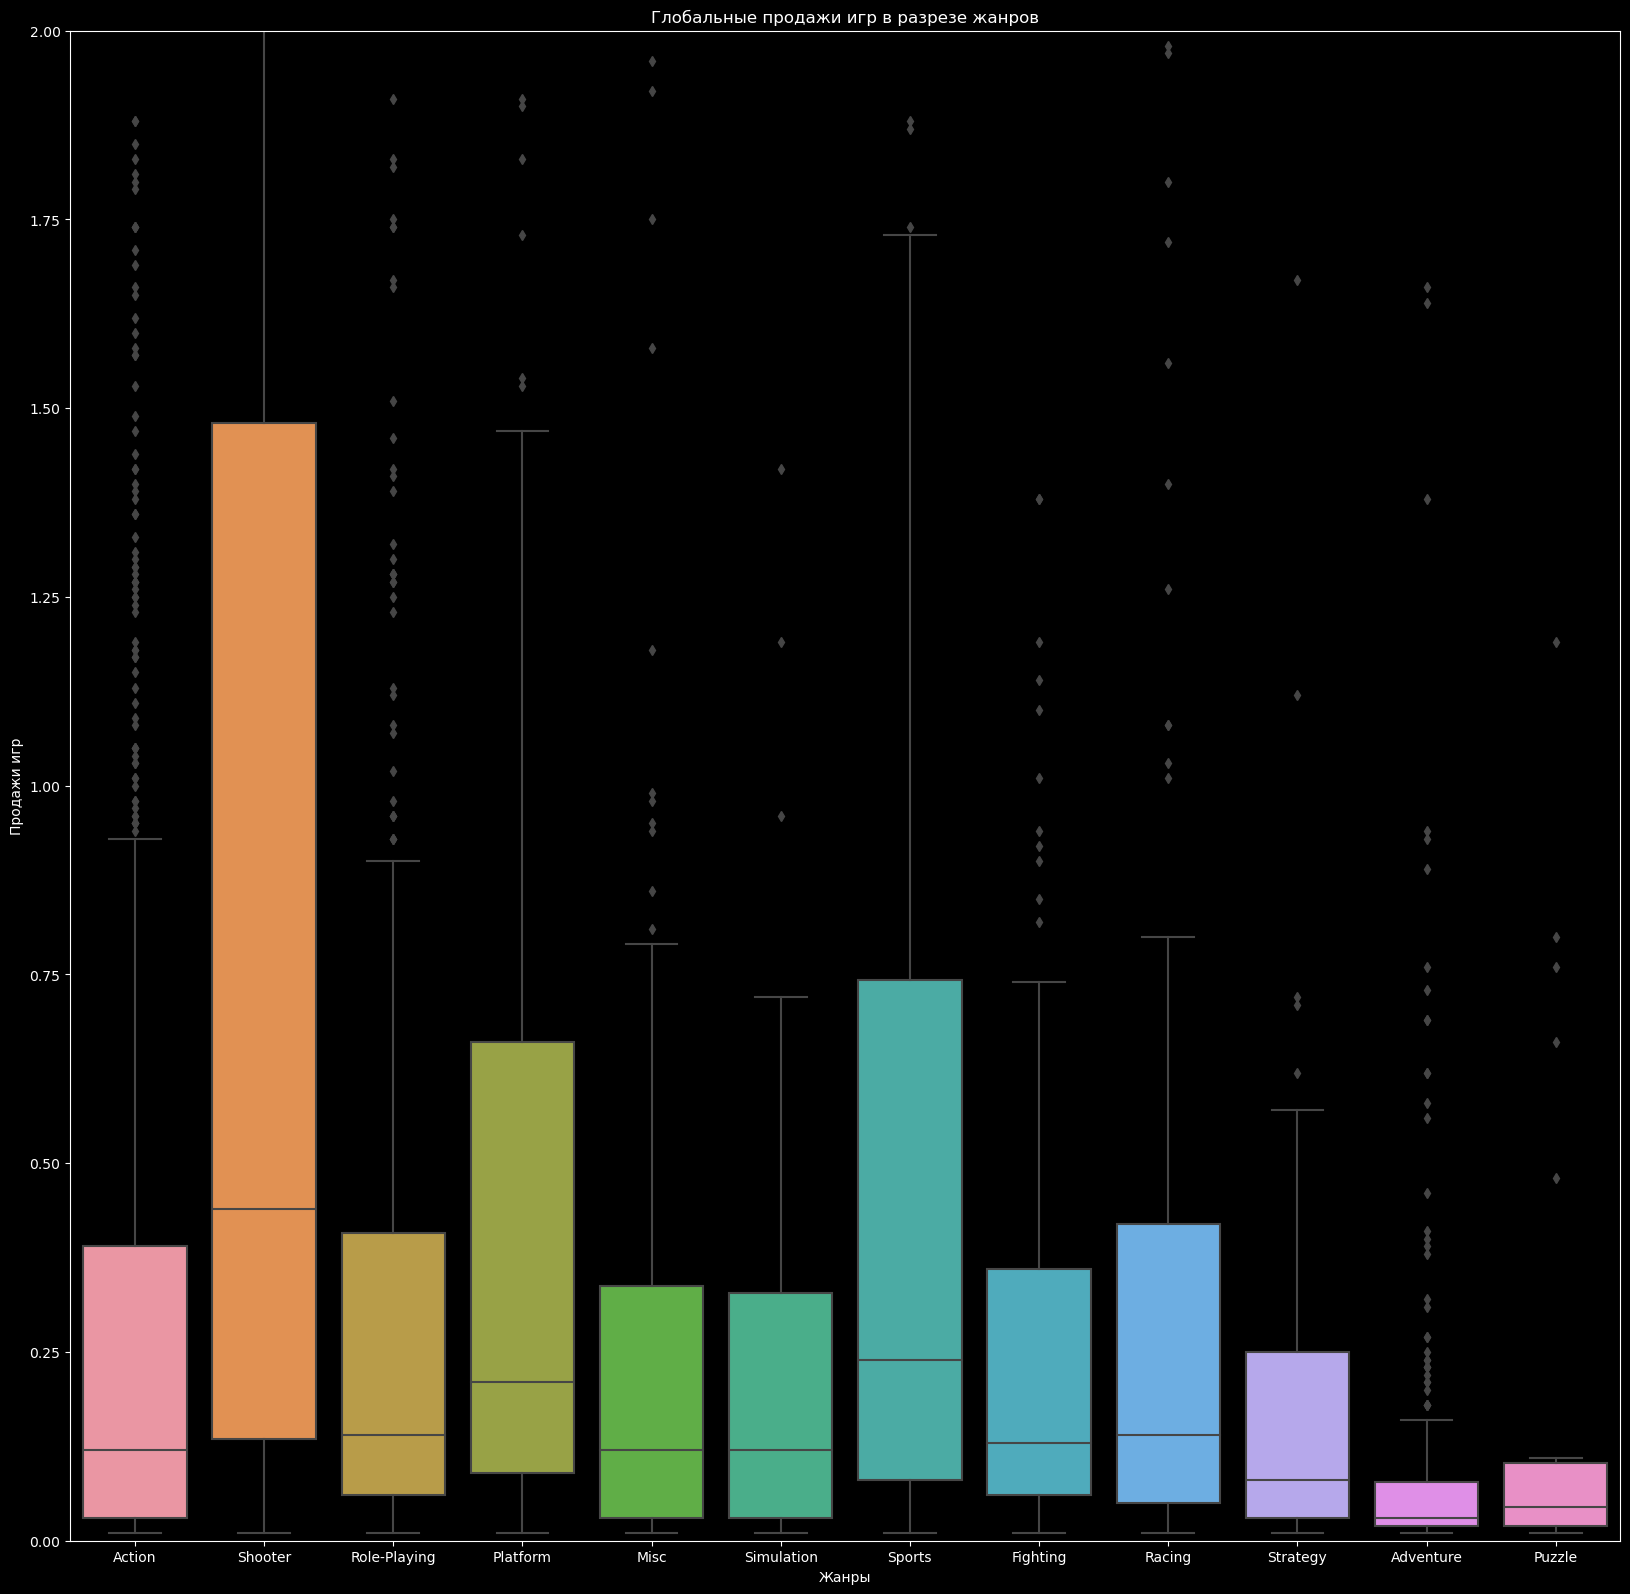

In [37]:
fig, ax = plt.subplots(figsize=(20,20), dpi=100)

sns.boxplot(data=df, x='genre', y='general_sales', ax=ax)
plt.ylim(0, 2)

plt.xlabel('Жанры')
plt.ylabel('Продажи игр')
plt.title("Глобальные продажи игр в разрезе жанров");

Самые ТОПовые жанры по продажам за все годы являются Shooter, на втором месте с большим отрывом расположился жанр Sports. Из антиТОПовых выделяются Puzzle и Adventure.

## Составим портрет пользователя каждого региона

### Самые популярные платформы (топ-5).

In [38]:
top5_platforms = df.groupby('platform')['general_sales'].sum().sort_values(ascending=False).head().index

In [39]:
def top5_platform(value):
    if value in list(top5_platforms):
        return value
    else:
        return 'other platforms'
    
df['top_platform'] = df['platform'].apply(top5_platform)

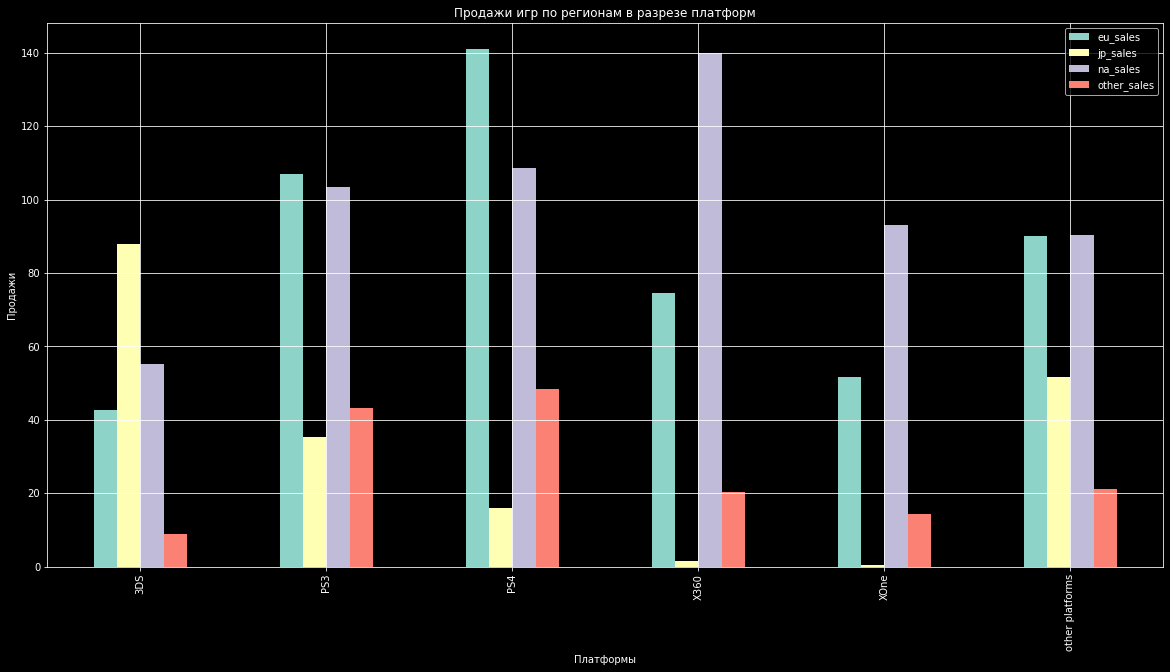

In [40]:
df.pivot_table(index='top_platform', values=['na_sales','eu_sales','jp_sales','other_sales'], aggfunc='sum')\
    .plot(kind='bar', figsize=(20,10), grid=True)

plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.title("Продажи игр по регионам в разрезе платформ");

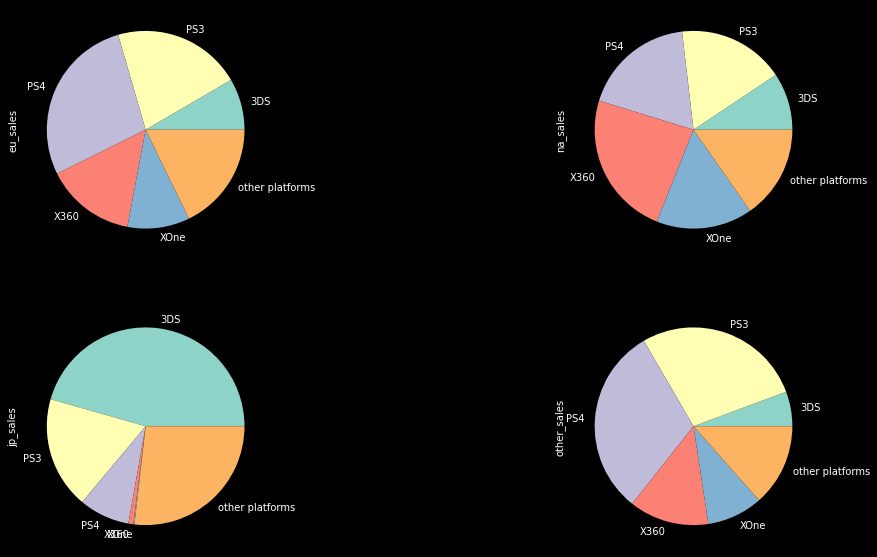

In [41]:
fig, axis = plt.subplots(2,2, figsize=(18,10))

df.groupby('top_platform')['eu_sales'].sum().plot.pie(ax=axis[0,0])
df.groupby('top_platform')['na_sales'].sum().plot.pie(ax=axis[0,1])
df.groupby('top_platform')['jp_sales'].sum().plot.pie(ax=axis[1,0])
df.groupby('top_platform')['other_sales'].sum().plot.pie(ax=axis[1,1]);

Из диаграмм видно, что на каждом рынке есть свой чемпион: в Европе это PS4, в Северной Америке - X360, в Японии - 3DS. В остальной части света PS4 обогнала по продажам PS3 и заняла лидирующую позицию.

### Самые популярные жанры (топ-5).

In [42]:
top5_genres = df.groupby('genre')['general_sales'].sum().sort_values(ascending=False).head().index

In [43]:
top5_genres

Index(['Action', 'Shooter', 'Role-Playing', 'Sports', 'Misc'], dtype='object', name='genre')

In [44]:
def top5_genre(value):
    if value in list(top5_genres):
        return value
    else:
        return 'other genres'
    
df['top_genres'] = df['genre'].apply(top5_genre)

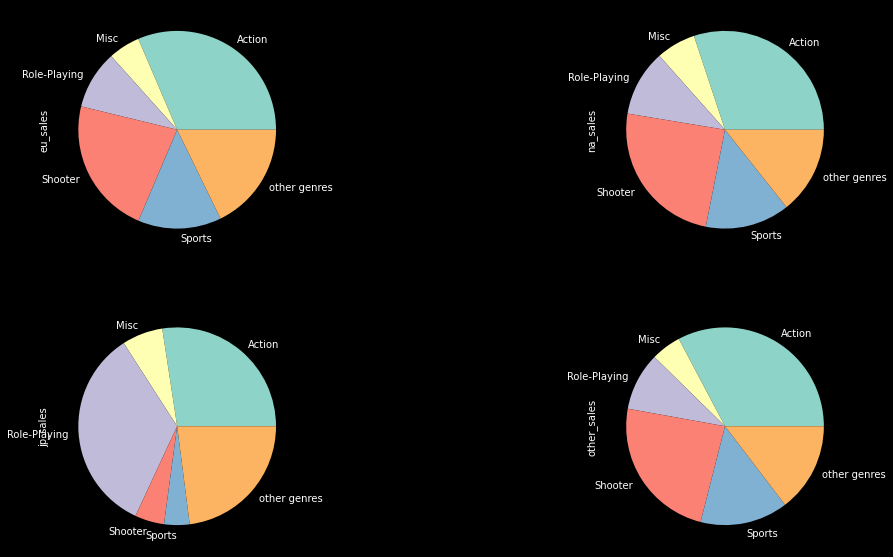

In [45]:
fig, axis = plt.subplots(2,2, figsize=(18,10))

df.groupby('top_genres')['eu_sales'].sum().plot.pie(ax=axis[0,0])
df.groupby('top_genres')['na_sales'].sum().plot.pie(ax=axis[0,1])
df.groupby('top_genres')['jp_sales'].sum().plot.pie(ax=axis[1,0])
df.groupby('top_genres')['other_sales'].sum().plot.pie(ax=axis[1,1]);

Во всем мире любят Action, пострелять и поиграть в спортивные игры, и только в Японии преобладает жанр Role-Playing, возможно это связано с местным менталитетом.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [46]:
df['rating'].unique()

array(['M', nan, 'E', 'E10+', 'T'], dtype=object)

Добавим столбец "value_rating" c расшифровкой рейтинга.

In [47]:
def translate_rating(value):
    if value == 'M':
        return 'Для взрослых'
    elif value == 'E':
        return 'Для всех'
    elif value == 'E10+':
        return 'Для всех от 10 лет и старше'
    elif value == 'T':
        return 'Подросткам'
    else:
        return 'Рейтинг не определен'

In [48]:
df['value_rating'] = df['rating'].apply(translate_rating)

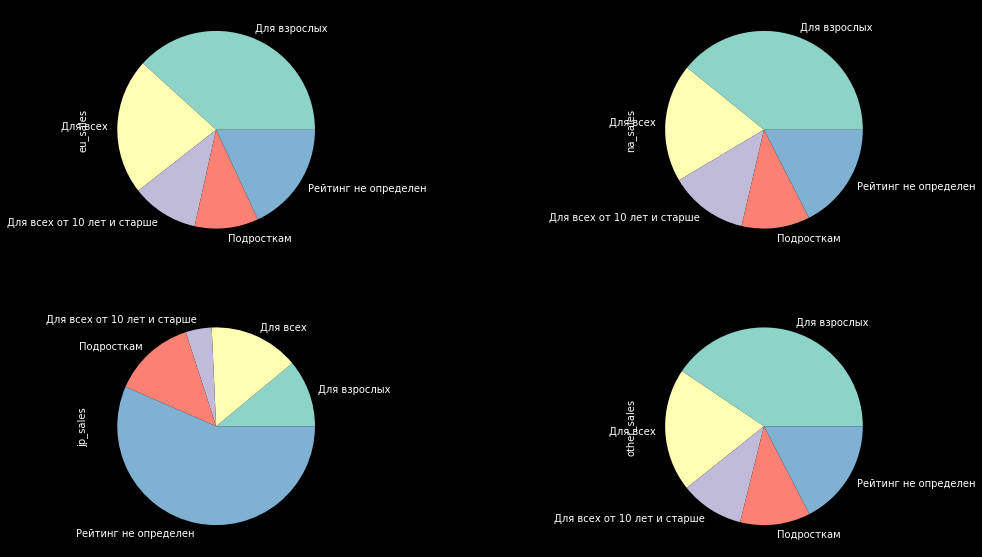

In [49]:
fig, axis = plt.subplots(2,2, figsize=(18,10))

df.groupby('value_rating')['eu_sales'].sum().plot.pie(ax=axis[0,0])
df.groupby('value_rating')['na_sales'].sum().plot.pie(ax=axis[0,1])
df.groupby('value_rating')['jp_sales'].sum().plot.pie(ax=axis[1,0])
df.groupby('value_rating')['other_sales'].sum().plot.pie(ax=axis[1,1]);

Во всем мире преобладают продажи игр для взрослых, в Японии же большей популярностью пользуются игры без рейтинга.

## Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H₀: средний пользовательский рейтинг платформ Xbox One и PC одинаковый;
H₁: средний пользовательский рейтинг платформ Xbox One и PC не одинаковый.

In [50]:
user_scores_xone = df[(df['platform'] == 'XOne') & (~df['user_score'].isna())]['user_score']
user_scores_pc = df[(df['platform'] == 'PC')& (~df['user_score'].isna())]['user_score']

In [51]:
alpha = .05

results_platform = st.ttest_ind(user_scores_xone, user_scores_pc)

print('p-значение:', results_platform.pvalue)

if results_platform.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


In [52]:
df[df['platform'].isin(['XOne', 'PC'])].groupby('platform')['user_score'].mean()

platform
PC      6.428641
XOne    6.521429
Name: user_score, dtype: float64

Т.к. это две генеральные совокупности не зависящие друго от друга мы применил Т-тест для о равенстве средних двух генеральных совокупностей. Тест показал, что мы не можем отвергнуть нулевую гипотезу, соответственно делаем вывод, что средний пользовательский рейтинг двух платформ одинаковый.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H₀: средний пользовательский рейтинг жанров Action и Sports одинаковый; H₁: средний пользовательский рейтинг жанров Action и Sports не одинаковый.

In [53]:
user_scores_action = df[(df['genre'] == 'Action') & (~df['user_score'].isna())]['user_score']
user_scores_sports = df[(df['genre'] == 'Sports')& (~df['user_score'].isna())]['user_score']

In [54]:
alpha = .05

results_genre = st.ttest_ind(user_scores_action, user_scores_sports, equal_var = False)

print('p-значение:', results_genre.pvalue)

if results_genre.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


In [55]:
df[df['genre'].isin(['Action', 'Sports'])].groupby('genre')['user_score'].mean()

genre
Action    6.825048
Sports    5.455897
Name: user_score, dtype: float64

Т.к. это две генеральные совокупности не зависящие друго от друга, но разного размера, мы применил Т-тест для о равенстве средних двух генеральных совокупностей с параметром equal_var = False. Тест показал низкий p-уровень значимости, что дает нам право отвергнуть нулевую гипотизу и заявить, что средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

В настоящий момент индустрия игр переживает спад и важно сейчас делать ставку на максимально прибыльный продукт.
Самым прибыльным продуктом на данный момент будут игры на платформе X360 в жанре Shooter с рейтингом ESRB "M" на Северо Американском рынке.
Также хочу отметить, что отзывы критиков и пользователей не сильно влияют при хорошей маркетинговой поддержке.